# Import libraries

In [1]:
import sklearn
print(sklearn.__version__)

0.23.2


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from geopy.geocoders import Nominatim
from geopy.distance import geodesic

from sklearn.datasets import load_digits
from sklearn import manifold

from scipy.spatial.distance import pdist, squareform

from joblib import Memory
location = './cachedir'
memory = Memory(location, verbose=0)

import folium

from scipy.stats import zscore

# %matplotlib notebook
import matplotlib.gridspec as gridspec

METRIC = True
CAPITALS = ['Yerevan','Istanbul','Cairo','Konya','Isfahan']

def remove_top_right(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax


from sklearn.metrics import euclidean_distances

def plot_mds(similarities,ax,input_is_corr=False,xlim=None,ylim=None):
    # similarities is a dissimilarity matrix
        
    # plt.matshow(similarities)
    seed = np.random.RandomState(seed=3)
    mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-21, random_state=seed,
                       dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(similarities).embedding_
    if METRIC is False:
        nmds = manifold.MDS(n_components=2, metric=False, max_iter=300000, eps=1e-19,
                            dissimilarity="precomputed", random_state=seed, n_jobs=4,
                            n_init=1)
        pos = nmds.fit_transform(similarities, init=pos)    
    ax.plot(pos[:,0],pos[:,1],'ok',markersize=15)
    for i, txt in enumerate(symm_df.columns):
        ax.annotate(txt, (pos[i,0]+2,  pos[i,1]),fontsize=15)
    ax.set_ylabel('Dim2',fontsize=20)
    ax.set_xlabel('Dim1',fontsize=20)
    ax = remove_top_right(ax)
    ax.grid()
    plt.tight_layout()
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=15)
#     ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    if xlim is not None:
        S=xlim/2.0
        Tx = np.arange(-xlim, xlim+S,step=S)
        Ty = np.arange(-ylim, ylim+S,step=S)
        ax.set_xticks(Tx)
        ax.set_yticks(Ty)
        ax.set_ylim(-ylim,ylim)
        ax.set_xlim(-xlim,xlim)
    return ax

def correlation_panel(corr,ax,input_is_corr=False,TITLE='Correlation Matrix',annotate=True,cbar=True,MASK=None,fmt=".1"):
    # corr is a distance matrix
    # plot the heatmap
    TICKLABELS = corr.columns.str.replace(' ','\n')
    if annotate is True:
        sns.heatmap(corr, 
                xticklabels=TICKLABELS,
                yticklabels=TICKLABELS,
                cmap="RdBu_r",
                square=True,
                ax=ax,
                cbar_kws={"shrink": 0.5},
                annot=corr.values,
                cbar=cbar,mask=MASK,
                fmt=fmt,
                linewidth=1)
    else:
        sns.heatmap(corr, 
        xticklabels=TICKLABELS,
        yticklabels=TICKLABELS,
        cmap="RdBu_r",
        square=True,
        ax=ax,
        cbar_kws={"shrink": 0.5},
        cbar=cbar,
        mask=MASK,
        linewidth=1)
    ax.set_title(TITLE,fontsize=16)
    ax.set_yticklabels(TICKLABELS,fontsize=12,va='center')
    ax.set_xticklabels(TICKLABELS,fontsize=12,ha='center')
    plt.tight_layout()
    return ax
    #biraz deli bir renk oldu ama simdilik kalsin.
    
@memory.cache
def get_geo_distances(capitals):
    geolocator = Nominatim(user_agent="bla")
    Distance = np.zeros((len(capitals),len(capitals)))
    for i,c1 in enumerate(capitals):
        for j,c2 in enumerate(capitals):
            l1 = geolocator.geocode(c1)
            l2 = geolocator.geocode(c2)
            d = geodesic(l1.point, l2.point).km
            Distance[i,j] = d
    return Distance


# Import Data

In [3]:
symm_df = pd.read_excel("./data_paper_Greek.xlsx",index_col=0)
symm_df = symm_df.iloc[:17,[3,2,1,4,5,0,6]]
symm_df = symm_df.astype(float)

In [4]:
symm_df

,Ermeni,Bizans,Arap,Selçuk,Ispanya,BuSel G,Yunan?
p1,0.8,14.04,0.00,0.27,1.000,0.8,9.8
p1m1,4.9,9.65,0.00,0.00,0.000,0.0,1.6
p1g1,0.0,0.88,0.00,0.00,0.000,0.8,0.0
c1m1,2.4,4.39,0.00,0.55,0.000,0.0,1.6
p211,0.0,2.63,3.60,1.10,1.000,2.4,0.0
p2mm,5.7,9.65,5.78,8.79,1.942,6.4,6.6
p2mg,0.8,5.26,0.44,0.82,0.000,0.8,1.6
p2gg,0.8,0.88,0.00,0.55,0.000,3.2,0.0
c2mm,1.6,3.51,12.89,8.52,1.942,11.2,6.6
p3,0.8,0.00,0.00,0.82,1.000,0.0,0.0


In [5]:
symm_df.sum()

Ermeni     100.000
Bizans     100.010
Arap        99.990
Selçuk      99.990
Ispanya    100.088
BuSel G    100.000
Yunan?      99.900
dtype: float64

In [6]:
dist_symm = pd.DataFrame(squareform(pdist(symm_df.T.values,'correlation'))
                            ,index=symm_df.columns, columns= symm_df.columns)
TOTAL_CULTURE = dist_symm.shape[0]
dist_symm

,Ermeni,Bizans,Arap,Selçuk,Ispanya,BuSel G,Yunan?
Ermeni,0.000000,0.151601,0.360039,0.280780,0.051315,0.225098,0.043894
Bizans,0.151601,0.000000,0.573249,0.520043,0.269017,0.408869,0.072603
Arap,0.360039,0.573249,0.000000,0.026510,0.407674,0.116362,0.409957
Selçuk,0.280780,0.520043,0.026510,0.000000,0.309204,0.079154,0.357268
Ispanya,0.051315,0.269017,0.407674,0.309204,0.000000,0.222001,0.140403
BuSel G,0.225098,0.408869,0.116362,0.079154,0.222001,0.000000,0.276082
Yunan?,0.043894,0.072603,0.409957,0.357268,0.140403,0.276082,0.000000


In [7]:
dist_symm_euc = pd.DataFrame(squareform(pdist(symm_df.T.values))
                            ,index=symm_df.columns, columns= symm_df.columns)
dist_symm_euc

,Ermeni,Bizans,Arap,Selçuk,Ispanya,BuSel G,Yunan?
Ermeni,0.000000,28.763503,40.484055,35.974045,17.001152,34.427315,18.156817
Bizans,28.763503,0.000000,40.919348,35.912037,36.893642,29.527294,29.967601
Arap,40.484055,40.919348,0.000000,10.315270,44.205578,20.302874,48.339577
Selçuk,35.974045,35.912037,10.315270,0.000000,38.873000,14.190980,45.628060
Ispanya,17.001152,36.893642,44.205578,38.873000,0.000000,35.993510,30.486987
BuSel G,34.427315,29.527294,20.302874,14.190980,35.993510,0.000000,43.261184
Yunan?,18.156817,29.967601,48.339577,45.628060,30.486987,43.261184,0.000000


# Histogram of Symmetry Groups

<IPython.core.display.Javascript object>


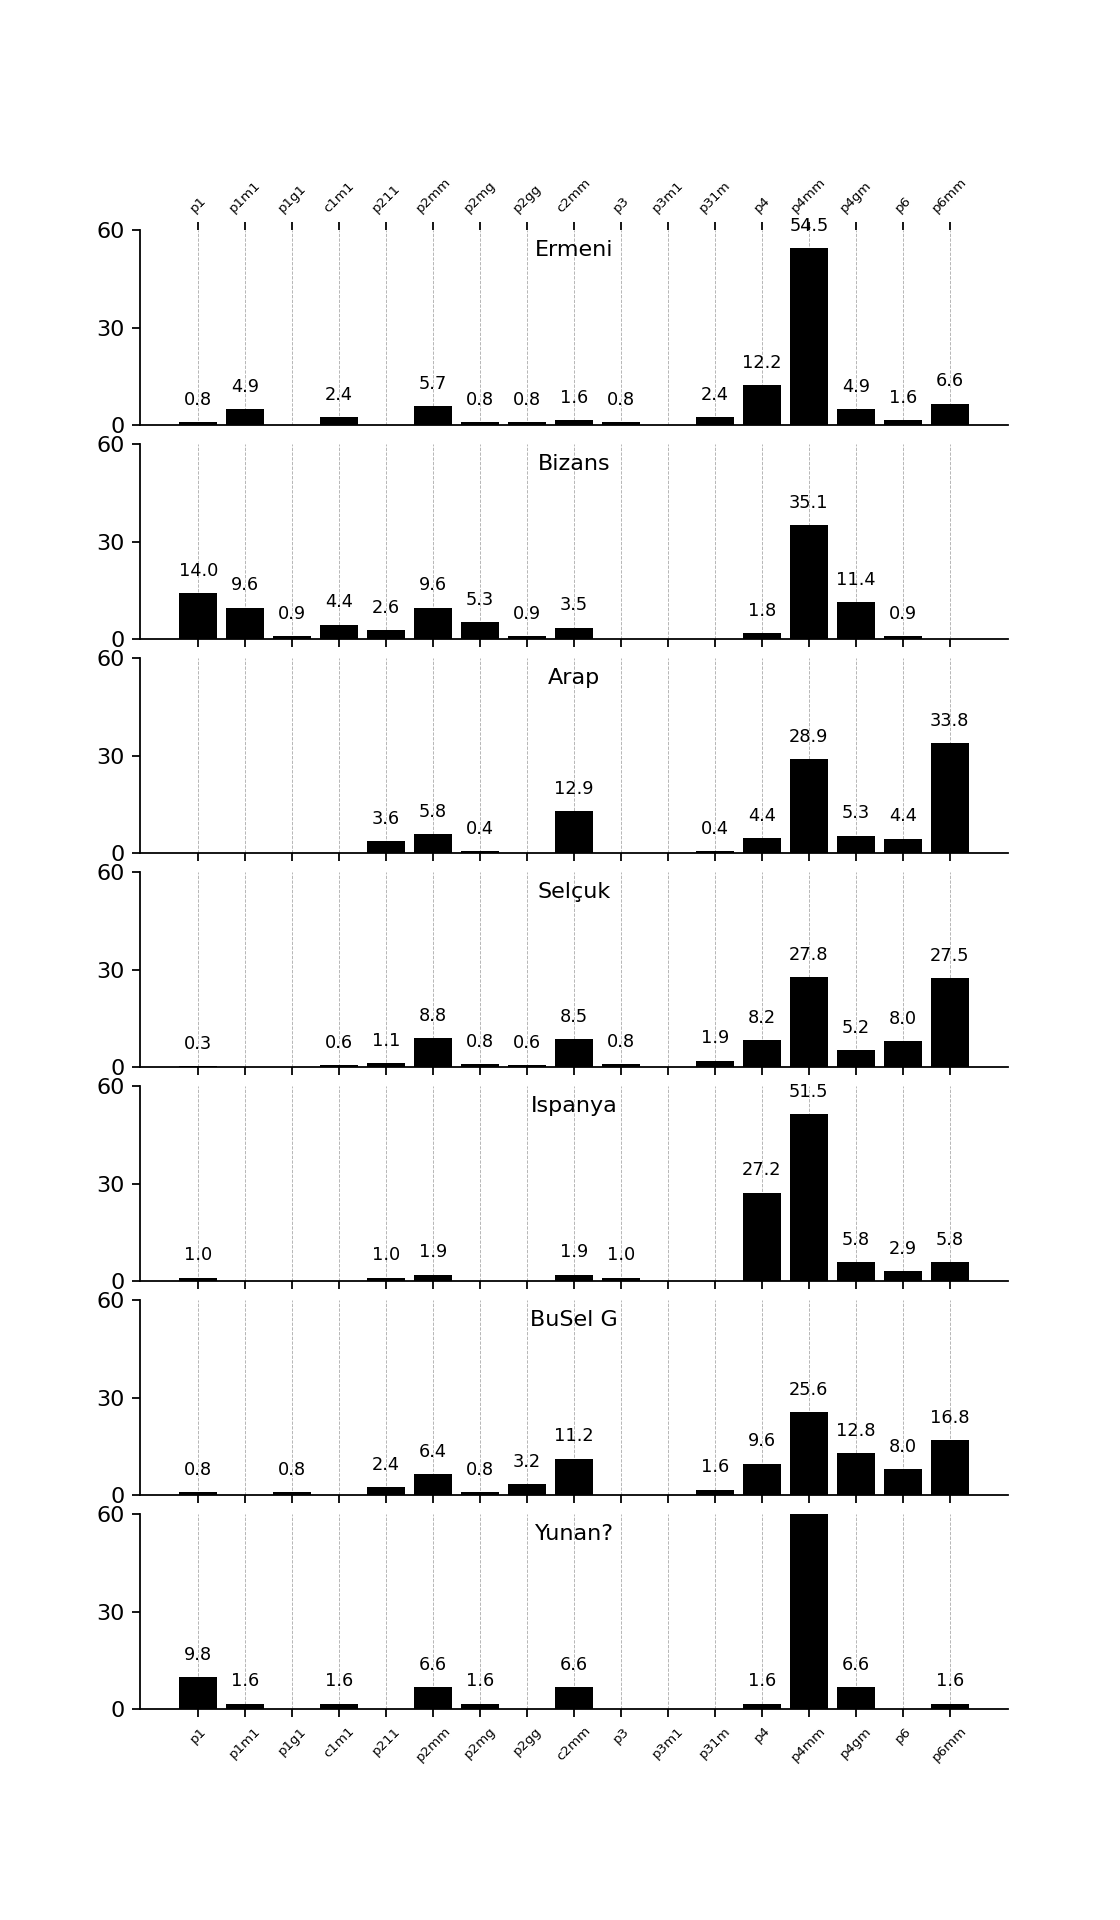

In [9]:
%matplotlib notebook
## FIGURE
fig = plt.figure(figsize=(TOTAL_CULTURE,12))
gs1 = gridspec.GridSpec(TOTAL_CULTURE,1)
gs1.update( hspace=0.1) # set the spacing between axes. 


cols = symm_df.columns.to_list() 
for i in np.arange(TOTAL_CULTURE):
    ax = plt.subplot(gs1[i])
    ax.bar(range(0,17),symm_df[cols[i]],color='k')
    ax = remove_top_right(ax)
    ax.set_xticks(np.arange(symm_df.shape[0]))
    if i == TOTAL_CULTURE-1:
        ax.set_xticklabels(symm_df.index.to_list(),rotation=45,fontsize=6,ha='center')
    elif i == 0:
        ax.set_xticklabels(symm_df.index.to_list(),rotation=45,fontsize=6,ha='center')
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top') 
    else:
        ax.set_xticklabels('')
    for p in ax.patches:
        if np.ceil(p.get_height()) != 0:
            ax.annotate(np.round(p.get_height(),decimals=1),
                        (p.get_x()+p.get_width()/2., 
                         p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',fontsize=8)
    ax.set_title(cols[i], y=0.8, loc = 'center',fontsize=10)
    ax.set_ylim([0,60])
    ax.set_yticks([0,30,60])
    ax.grid(axis='x', linestyle='--', linewidth=.4)
    ax.set_axisbelow(True)

    
plt.subplots_adjust(hspace=.5)
# plt.savefig('/Users/sonat/Documents/repos/ornament_symmgroups/figure_histograms.png',dpi=1000)

# Correlation between Symmetry Groups

<IPython.core.display.Javascript object>


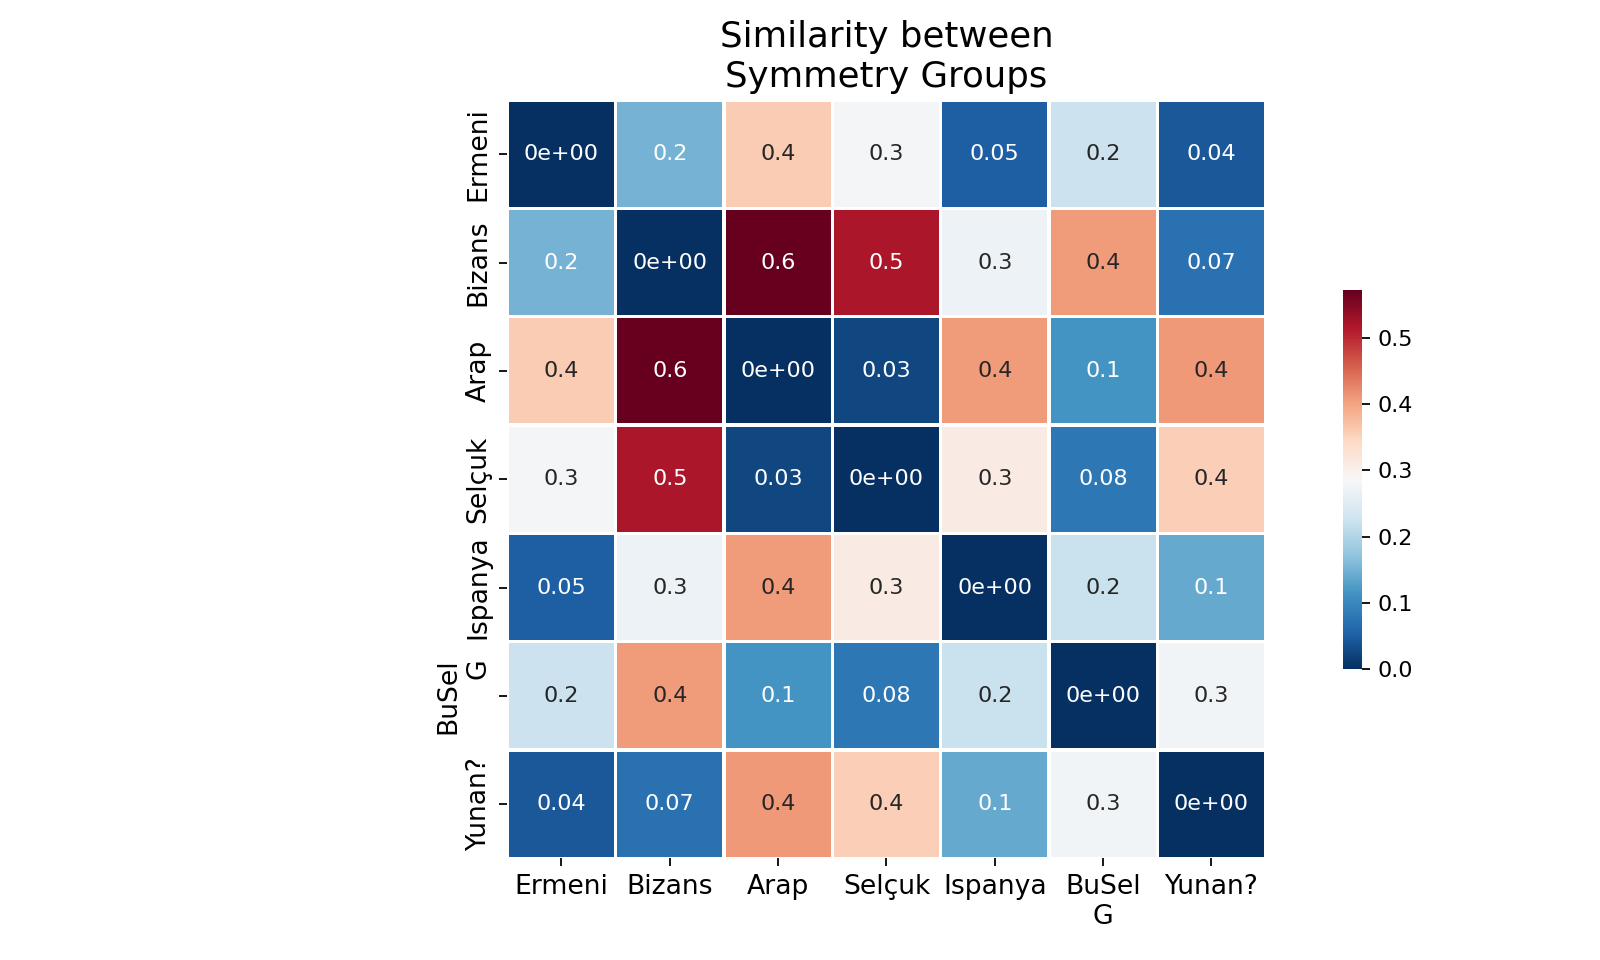

<AxesSubplot:title={'center':'Similarity between\nSymmetry Groups'}>

In [10]:
fig = plt.figure(figsize=(10,6))
ax  = fig.subplots(1,1)
# mask = np.triu(np.ones((5, 5), dtype=bool),0)==False
correlation_panel(dist_symm,ax=ax,TITLE='Similarity between\nSymmetry Groups')

# plt.savefig('/Users/sonat/Documents/repos/ornament_symmgroups/figure_corrmat.png',
#                 dpi=1000,
#                 )

# Euclidean Distance between Groups

<IPython.core.display.Javascript object>


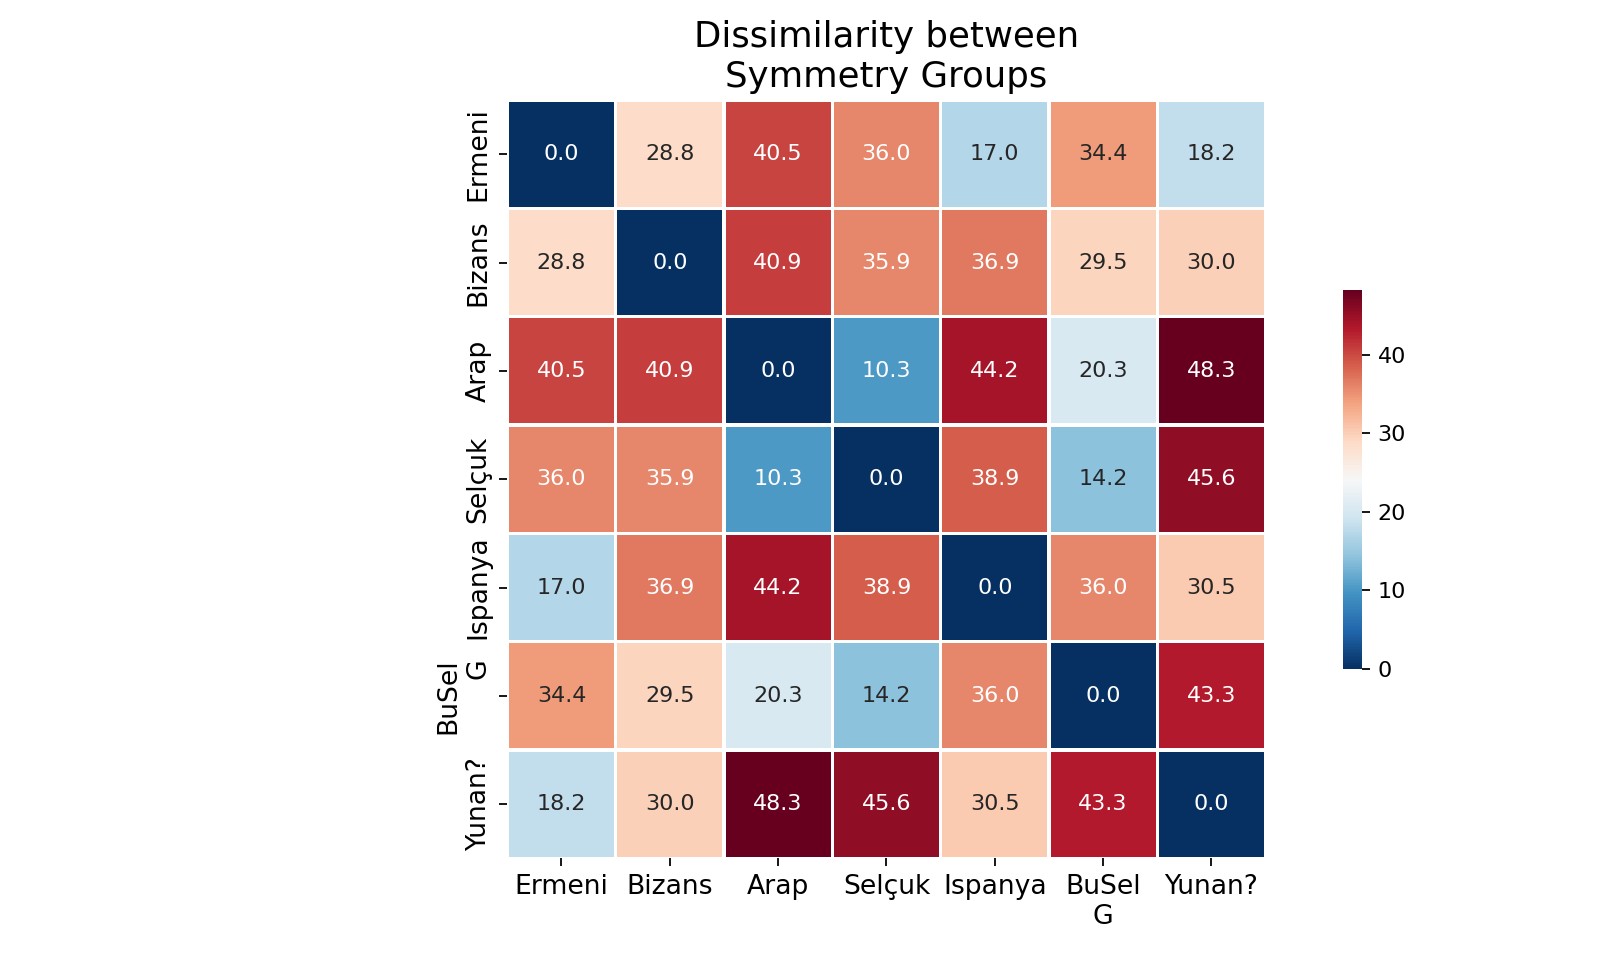

<AxesSubplot:title={'center':'Dissimilarity between\nSymmetry Groups'}>

In [11]:
fig = plt.figure(figsize=(10,6))
ax  = fig.subplots(1,1)
# mask = np.triu(np.ones((5, 5), dtype=bool),0)==False
correlation_panel(dist_symm_euc,ax=ax,TITLE='Dissimilarity between\nSymmetry Groups',fmt='.1f')

# plt.savefig('/Users/sonat/Documents/repos/ornament_symmgroups/figure_eucmat.png',
#                 dpi=1000,
#                 )

# MDS on Symmetry Similarity

<IPython.core.display.Javascript object>


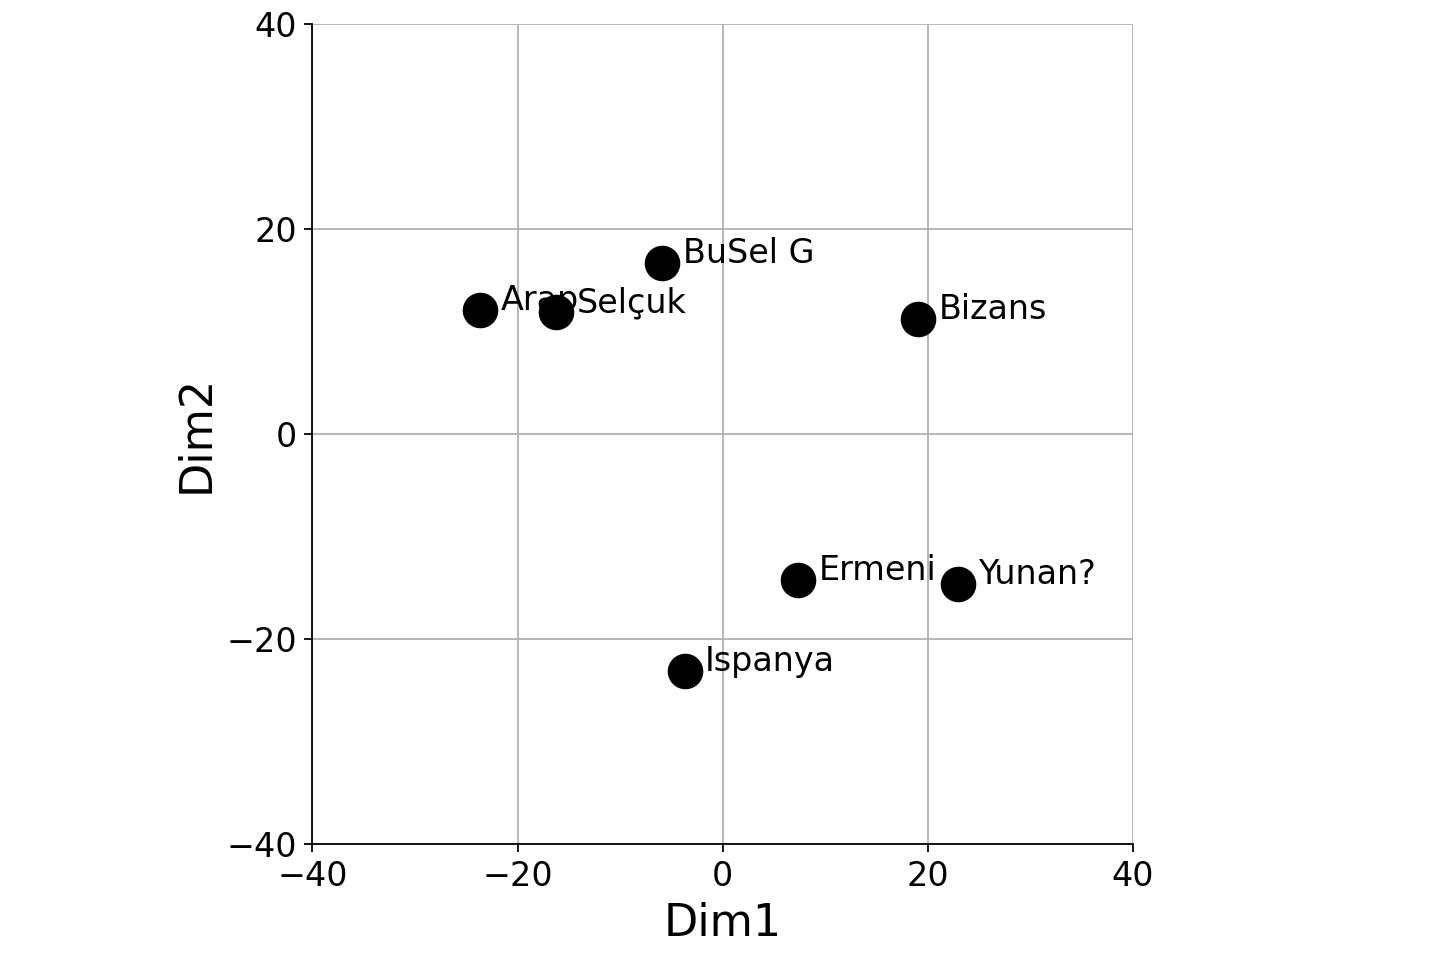

In [13]:
fig = plt.figure(figsize=(9,6))
ax  = fig.subplots(1,1)
ax  = plot_mds(dist_symm_euc ,ax,xlim=40,ylim=40)
# plt.savefig('/Users/sonat/Documents/repos/ornament_symmgroups/figure_mds.png',dpi=1000)